In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score, precision_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import copy
import matplotlib.pyplot as plt
import csv
import os

In [36]:
# df = pd.read_csv('/Users/anika/Desktop/BEM:EC 120/features_basic.csv')
df = pd.read_csv('/Users/anika/Desktop/BEM:EC 120/generated_datasets/atp_features_0425.csv')

In [37]:
df.columns

Index(['match_id', 'server', 'opponent', 'hand_combo', 'surface',
       'game_advantage', 'set_advantage', 'point_advantage', 'pts_in_game',
       'pts_in_match', 'is_break_point', 'op_error_deuce_side_last20',
       'op_error_ad_side_last20', 'op_error_middle_last20',
       's1_success_rate_whole_match', 'wide_returner_win_recent_matches',
       'body_returner_win_recent_matches', 'wide_server_win_rate',
       'body_server_win_rate', 'T_server_win_rate',
       'T_returner_win_recent_matches', 'returner_win_1st/2nd_recent_matches',
       's1_success_recent_matches', 'court_side', 'first_serve_attempt',
       'serve_loc', 'first_shot_loc', 'won_pt', 'is_forced_err',
       'rally_category', 'rally_length', 's1_success', 'data_split'],
      dtype='object')

In [11]:
# Drop all rows with missing values, or where 'first_shot_loc' is unknown or 'first_serve_attempt' is unknown or 'serve_loc' is unknown
df = df.dropna()
df = df[df['first_shot_loc'] != 'unknown']
df = df[df['first_serve_attempt'] != 'unknown']
df = df[df['serve_loc'] != 'unknown']

# If any values have a space in them, make it a _
df = df.replace(' ', '_', regex=True)

# make everything lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

# get rid of all columns where df['first_shot_loc'] == 'no_first_shot'
df = df[df['first_shot_loc'] != 'no_first_shot']
df['s+1'] = df['serve_loc'] + '_' + df['first_shot_loc']

len(df[df['data_split'] == 'train']), len(df[df['data_split'] == 'test']), len(df[df['data_split'] == 'fine_tune'])

(304671, 57550, 0)

In [12]:
for col in df.columns[3:]:
    print(f'{col}: {df[col].unique()}')
    print(f'{col}: {df[col].nunique()}')
    print('\n')

hand_combo: ['ll' 'rr' 'lr' 'rl']
hand_combo: 4


surface: ['hard' 'clay' 'grass']
surface: 3


game_advantage: [ 0 -1  1  2 -2  3 -3]
game_advantage: 7


set_advantage: [ 0 -1  1  2 -2  3 -3]
set_advantage: 7


point_advantage: [ 1  2  3  0 -1 -2 -3  4 -4 -5  5 -6  6 -7 -8  9  7]
point_advantage: 17


pts_in_game: [ 1  2  3  0  5  7  8  9 10 11 12 13  4  6 14 15 17 16 19 21 22 24 25 18
 23 20 27 29 31 28 26 30 32 33]
pts_in_game: 34


pts_in_match: [  2   3   4   5   6   7   8  10  12  13  14  15  16  17  18  19  20  22
  24  25  27  29  30  31  32  33  34  35  36  37  38  39  40  41  43  45
  46  47  48  49  51  53  55  56  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  75  76  78  80  81  82  84  85  86  87  88  89  90  91
  92  93  94  95  97  98  99 100 101 102 103 105 106 110 111 112 115 116
 117 118 119 120 121 122 123 124 126 127 129 130 131 133 135 136 140 142
 143 144 145 146 148 149 150 151 153 154 155 159 160   1   9  21  23  42
  44  54  74  77  79  83  11  28  5

In [13]:
def preprocess_data(df):

    # Columns to one-hot encode
    one_hot_cols = [
        'surface', 'hand_combo', 'court_side', 'first_serve_attempt',
        'serve_loc', 'first_shot_loc', 'is_break_point'
    ]

    # Label encode server and opponent (for embeddings)
    label_encoders = {}
    for col in ['server', 'opponent']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # One-hot encode categorical variables
    df = pd.get_dummies(df, columns=one_hot_cols)

    # Scale numerical variables
    scaler = StandardScaler()
    numerical_to_scale = ['game_advantage', 'set_advantage', 'point_advantage', 'pts_in_game', 'pts_in_match']
    df[numerical_to_scale] = scaler.fit_transform(df[numerical_to_scale])

    df['interaction_returns_wide'] = df['serve_loc_wide'] * df['wide_returner_win_recent_matches']
    df['interaction_returns_body'] = df['serve_loc_body'] * df['body_returner_win_recent_matches']
    df['interaction_returns_T'] = df['serve_loc_t'] * df['T_returner_win_recent_matches']

    df['interaction_+1_deuce'] = df['first_shot_loc_deuce_court'] * df['op_error_deuce_side_last20']
    df['interaction_+1_ad'] = df['first_shot_loc_ad_court'] * df['op_error_ad_side_last20']
    df['interaction_+1_middle'] = df['first_shot_loc_middle'] * df['op_error_middle_last20']

    df['interaction_serve_wide'] = df['serve_loc_wide'] * df['wide_server_win_rate']
    df['interaction_serve_body'] = df['serve_loc_body'] * df['body_server_win_rate']
    df['interaction_serve_T'] = df['serve_loc_t'] * df['T_server_win_rate']

    return df, label_encoders

In [14]:
df_preprocessed, label_encoders = preprocess_data(df)
df_preprocessed.columns

Index(['match_id', 'server', 'opponent', 'game_advantage', 'set_advantage',
       'point_advantage', 'pts_in_game', 'pts_in_match',
       'op_error_deuce_side_last20', 'op_error_ad_side_last20',
       'op_error_middle_last20', 's1_success_rate_whole_match',
       'wide_returner_win_recent_matches', 'body_returner_win_recent_matches',
       'wide_server_win_rate', 'body_server_win_rate', 'T_server_win_rate',
       'T_returner_win_recent_matches', 'returner_win_1st/2nd_recent_matches',
       's1_success_recent_matches', 'won_pt', 'is_forced_err',
       'rally_category', 'rally_length', 's1_success', 'data_split', 's+1',
       'surface_clay', 'surface_grass', 'surface_hard', 'hand_combo_ll',
       'hand_combo_lr', 'hand_combo_rl', 'hand_combo_rr', 'court_side_ad',
       'court_side_deuce', 'first_serve_attempt_body',
       'first_serve_attempt_made_first_serve', 'first_serve_attempt_t',
       'first_serve_attempt_wide', 'serve_loc_body', 'serve_loc_t',
       'serve_loc_wide'

In [30]:
# Features and target
categorical_cols = ['server', 'opponent']


# After one-hot encoding, collect all new columns
one_hot_prefixes = [
                    'hand_combo_',
                    'surface_',
                    's+1_'
                ]


numerical_cols = [col for col in df_preprocessed.columns if any(col.startswith(prefix) for prefix in one_hot_prefixes)] + [
    'game_advantage', 'set_advantage', 'point_advantage', 'pts_in_game',
    'pts_in_match', 'is_break_point_True',
    'first_serve_attempt_made_first_serve',
    'interaction_returns_wide', 'interaction_returns_body',
    'interaction_returns_T', 'interaction_+1_deuce', 'interaction_+1_ad',
    'interaction_+1_middle', 'interaction_serve_wide',
    'interaction_serve_body', 'interaction_serve_T',
    's1_success_recent_matches',
    's1_success_rate_whole_match',
    'returner_win_1st/2nd_recent_matches'
]

target_cols = ['won_pt']


In [31]:
class TennisDataset(Dataset):
    def __init__(self, df, categorical_cols, numerical_cols, target_cols):
        self.categorical_data = df[categorical_cols].values.astype(np.int64)
        self.numerical_data = df[numerical_cols].values.astype(np.float32)
        self.targets = df[target_cols].values.astype(np.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        x_cat = torch.tensor(self.categorical_data[idx], dtype=torch.long)
        x_num = torch.tensor(self.numerical_data[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)  # shape: [num_targets]
        return x_cat, x_num, y


In [32]:
# --- Step 3: MLP with Embeddings ---
class MultiTaskServePlusOneModel(nn.Module):
    def __init__(self, embedding_sizes, num_numerical, hidden_units):
        # Trials 1 - 3
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Sequential(
                nn.Embedding(categories, size),
            ) for categories, size in embedding_sizes
        ])
        self.emb_dim = sum(e[0].embedding_dim for e in self.embeddings)

        self.shared_fc = nn.Sequential(
            nn.Linear(self.emb_dim + num_numerical, hidden_units[0]),
            nn.ReLU(),
            nn.Dropout(0.2),  # Add dropout
            nn.Linear(hidden_units[0], hidden_units[1]),
            nn.ReLU(),
        )      

        # One output head per task
        self.output_won = nn.Linear(hidden_units[1], 1)

    def forward(self, x_cat, x_num):
        emb_outs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        emb_cat = torch.cat(emb_outs, dim=1)
        x = torch.cat([emb_cat, x_num], dim=1)
        shared = self.shared_fc(x)

        out_won = self.output_won(shared)
        return out_won
    
class ServePlusOneMLPv2(nn.Module):
    def __init__(self, embedding_sizes, num_numerical, hidden_units=[128, 64, 32], dropout=0.1):
        super().__init__()
        
        # Embedding layers (only for player/opponent)
        self.embeddings = nn.ModuleList([
            nn.Embedding(categories, size) for categories, size in embedding_sizes
        ])
        self.emb_dim = sum(e.embedding_dim for e in self.embeddings)

        self.batchnorm_input = nn.BatchNorm1d(self.emb_dim + num_numerical)

        # Hidden layers
        layers = []
        input_dim = self.emb_dim + num_numerical

        for hidden in hidden_units:
            layers.append(nn.Linear(input_dim, hidden))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden))
            layers.append(nn.Dropout(dropout))
            input_dim = hidden

        self.shared_fc = nn.Sequential(*layers)
        self.output = nn.Linear(hidden_units[-1], 1)

    def forward(self, x_cat, x_num):
        emb_outs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        emb_cat = torch.cat(emb_outs, dim=1)

        x = torch.cat([emb_cat, x_num], dim=1)
        x = self.batchnorm_input(x)
        x = self.shared_fc(x)
        return self.output(x)


In [33]:
# --- Step 4: Training and Evaluation Loop ---
def train_model(model, dataloader, optimizer, criterion_won, device='cpu'):
    model.train().to(device)  # Ensure model is on correct device
    total_loss = 0
    total_samples = 0

    for x_cat, x_num, y in dataloader:
        x_cat, x_num, y = x_cat.to(device), x_num.to(device), y.to(device)
        optimizer.zero_grad()

        # Forward pass
        out_won = model(x_cat, x_num)

        # Calculate loss
        loss = criterion_won(out_won.squeeze(), y[:, 0])

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item() * x_cat.size(0)  # Weight by batch size
        total_samples += x_cat.size(0)

    return total_loss / total_samples  # Return average loss per sample


def evaluate_model(model, dataloader, criterion_won, device='cpu'):
    model.eval().to(device)
    total_loss = 0
    total_samples = 0
    
    won_preds = []
    won_targets = []
    
    with torch.no_grad():
        for x_cat, x_num, y in dataloader:
            x_cat, x_num, y = x_cat.to(device), x_num.to(device), y.to(device)
            out_won = model(x_cat, x_num)
            
            loss = criterion_won(out_won.squeeze(), y[:, 0])
            total_loss += loss.item() * x_cat.size(0)
            total_samples += x_cat.size(0)
            
            won_preds.extend(torch.sigmoid(out_won).view(-1).cpu().tolist())
            won_targets.extend(y[:, 0].cpu().numpy())
    
    avg_loss = total_loss / total_samples
    
    won_metrics = calculate_binary_metrics(
        np.array(won_preds),
        np.array(won_targets),
        threshold=0.5
    )
        
    return {
        'loss': avg_loss,
        'won_metrics': won_metrics,
    }

def calculate_binary_metrics(preds, targets, threshold=0.5):
    # Apply threshold to get binary predictions
    binary_preds = (preds >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(targets, binary_preds) # Accuracy is the ratio of correct predictions to total predictions
    precision = precision_score(targets, binary_preds, zero_division=0) # Precision = true positives / true positives + false positives (combos that were predicted to win actually won) 
    recall = recall_score(targets, binary_preds, zero_division=0) # Recall = true positives / true positives + false negatives (combos that won were actually predicted to win)
    f1 = f1_score(targets, binary_preds, zero_division=0) # F1 score = 2 * (precision * recall) / (precision + recall)
    roc_auc = roc_auc_score(targets, preds) # ability to distinguish between classes
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pred_probs': preds,  # Raw probabilities for further analysis
        'targets': targets,    # Ground truth labels
        'ratio': np.mean(binary_preds)
    }

In [34]:
def train_and_evaluate(categorical_cols, numerical_cols, target_cols, embedding_size, lr, batch_size, epochs, hidden_units = [64, 32], pos_weight = True, notes = ''):
    # Define embedding sizes
    embedding_sizes = [(len(label_encoders[col].classes_), min(embedding_size, (len(label_encoders[col].classes_) + 1) // 2))
                    for col in categorical_cols]

    # Create dataset and dataloader
    df_train = df_preprocessed[df_preprocessed['data_split'] == 'train'].drop('data_split', axis=1)
    df_test = df_preprocessed[df_preprocessed['data_split'] == 'test'].drop('data_split', axis=1)
    df_fine_tune = df_preprocessed[df_preprocessed['data_split'] == 'test'].drop('data_split', axis=1)

    dataset_train = TennisDataset(df_train, categorical_cols, numerical_cols, target_cols)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

    dataset_test = TennisDataset(df_test, categorical_cols, numerical_cols, target_cols)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    dataset_fine_tune = TennisDataset(df_fine_tune, categorical_cols, numerical_cols, target_cols)
    dataloader_fine_tune = DataLoader(dataset_fine_tune, batch_size=batch_size, shuffle=True)

    model = MultiTaskServePlusOneModel(embedding_sizes, num_numerical=len(numerical_cols), hidden_units=hidden_units)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    criterion_won = nn.BCEWithLogitsLoss()

    # Because we have a sligtly unbalanced dataset
    if pos_weight:
        pos_ratio = df_train[target_cols[0]].mean()
        neg_ratio = 1 - pos_ratio
        pos_weight = torch.tensor(neg_ratio / pos_ratio)
        criterion_won = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    train_losses, val_losses = [], []
    for epoch in range(epochs):
        train_loss = train_model(model, dataloader_train, optimizer, criterion_won)
        val_results = evaluate_model(model, dataloader_fine_tune, criterion_won)
        val_loss = val_results['loss']
        val_metrics = val_results['won_metrics']

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_metrics['accuracy']:.4f}, Val Precision = {val_metrics['precision']:.4f}, Val Recall = {val_metrics['recall']:.4f}, Val F1 = {val_metrics['f1']:.4f}, Val Ratio = {val_metrics['ratio']:.4f}")

    test_results = evaluate_model(model, dataloader_test, criterion_won)
    test_loss = test_results['loss']
    test_metrics = test_results['won_metrics']

    print(f"Test Loss = {test_loss:.4f}, Test Accuracy = {test_metrics['accuracy']:.4f}, Test Precision = {test_metrics['precision']:.4f}, Test Recall = {test_metrics['recall']:.4f}, Test F1 = {test_metrics['f1']:.4f}, Test Ratio = {test_metrics['ratio']:.4f}")

    # Write results to mlp_results.csv        
    results = {
        'categorical_cols': categorical_cols,
        'numerical_cols': numerical_cols,
        'target_cols': target_cols,
        'embedding_size': embedding_size,
        'hidden_units': hidden_units,
        'lr': lr,
        'batch_size': batch_size,
        'epochs': epochs,
        'pos_weight': pos_weight,
        'train_loss': train_losses,
        'val_loss': val_losses,
        'val_metrics': val_metrics,
        'test_loss': test_loss,
        'test_metrics': test_metrics,
        'notes': notes
    }

    with open('mlp_results.csv', 'a', newline='') as f:
        writer = csv.writer(f)
        
        # Write header if file is empty
        if os.stat('mlp_results.csv').st_size == 0:
            writer.writerow(results.keys())  # Write column names
        
        # Write values (order must match header)
        writer.writerow(results.values())
        
    print("Results written to mlp_results.csv")


In [35]:
train_and_evaluate(categorical_cols, numerical_cols, target_cols, embedding_size=64, lr=1e-3, batch_size=128, epochs=10, hidden_units=[128, 64], pos_weight=False, notes="new historical features")

Epoch 1: Train Loss = 0.6849, Val Loss = 0.6819, Val Accuracy = 0.5621, Val Precision = 0.5669, Val Recall = 0.7790, Val F1 = 0.6562, Val Ratio = 0.7374
Epoch 2: Train Loss = 0.6817, Val Loss = 0.6814, Val Accuracy = 0.5635, Val Precision = 0.5717, Val Recall = 0.7447, Val F1 = 0.6468, Val Ratio = 0.6991
Epoch 3: Train Loss = 0.6803, Val Loss = 0.6814, Val Accuracy = 0.5631, Val Precision = 0.5708, Val Recall = 0.7493, Val F1 = 0.6480, Val Ratio = 0.7044
Epoch 4: Train Loss = 0.6792, Val Loss = 0.6814, Val Accuracy = 0.5637, Val Precision = 0.5722, Val Recall = 0.7408, Val F1 = 0.6457, Val Ratio = 0.6948
Epoch 5: Train Loss = 0.6782, Val Loss = 0.6818, Val Accuracy = 0.5636, Val Precision = 0.5705, Val Recall = 0.7564, Val F1 = 0.6504, Val Ratio = 0.7116
Epoch 6: Train Loss = 0.6773, Val Loss = 0.6823, Val Accuracy = 0.5629, Val Precision = 0.5726, Val Recall = 0.7314, Val F1 = 0.6424, Val Ratio = 0.6855
Epoch 7: Train Loss = 0.6764, Val Loss = 0.6818, Val Accuracy = 0.5626, Val Precis

In [563]:
df_results = pd.read_csv('mlp_results.csv')
df_results.columns

Index(['categorical_cols', 'numerical_cols', 'target_cols', 'embedding_size',
       'hidden_units', 'lr', 'batch_size', 'epochs', 'pos_weight',
       'train_loss', 'val_loss', 'val_metrics', 'test_loss', 'test_metrics',
       'notes'],
      dtype='object')

In [575]:
print(df_results['test_metrics'].iloc[-5])
print(df_results['test_metrics'].iloc[-4])

{'accuracy': 0.5883106699562033, 'precision': 0.45477592729825655, 'recall': 0.6070703389389285, 'f1': 0.5200017838826205, 'roc_auc': 0.6264091024729056, 'pred_probs': array([0.46585545, 0.64793158, 0.44875121, ..., 0.46312156, 0.49693626,
       0.36779952]), 'targets': array([1., 0., 1., ..., 1., 1., 0.], dtype=float32), 'ratio': 0.49035133015854804}
{'accuracy': 0.5811960908065102, 'precision': 0.45062204117582294, 'recall': 0.639298172541261, 'f1': 0.5286292405717238, 'roc_auc': 0.6230248897189525, 'pred_probs': array([0.43988985, 0.59010524, 0.25440839, ..., 0.39396524, 0.48035419,
       0.36157072]), 'targets': array([1., 0., 1., ..., 1., 1., 0.], dtype=float32), 'ratio': 0.5211429227150152}


In [171]:
def fine_tune_model_on_player(model, player_df, categorical_cols, numerical_cols, target_cols, epochs=5, lr=1e-4, freeze_embeddings=False, freeze_shared=False):
    model_copy = copy.deepcopy(model)
    dataset = TennisDataset(player_df, categorical_cols, numerical_cols, target_cols)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    criterion_won = nn.BCELoss()
    criterion_forced = nn.BCELoss()
    # criterion_rally = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_copy.parameters(), lr=lr)

    # Optionally freeze layers
    if freeze_embeddings:
        for param in model_copy.embeddings.parameters():
            param.requires_grad = False

    if freeze_shared:
        for param in model_copy.shared_fc.parameters():
            param.requires_grad = False

    model_copy.train()
    # print("Starting fine-tuning for player:", player_df['server'].iloc[0])
    for _ in range(epochs):
        for x_cat, x_num, y in loader:
            optimizer.zero_grad()
            # out_won, out_forced, out_rally = model_copy(x_cat, x_num)
            out_won, out_forced = model_copy(x_cat, x_num)
            loss1 = criterion_won(out_won.view(-1), y[:, 0])
            loss2 = criterion_forced(out_forced.view(-1), y[:, 1])
            # loss3 = criterion_rally(out_rally, y[:, 2].long())
            # loss = loss1 + loss2 + loss3
            loss = loss1 + loss2
            loss.backward()
            optimizer.step()

    # print("Finished fine-tuning for player:", player_df['server'].iloc[0])
    return model_copy

In [193]:
def evaluate_serve_plus_one_combos(model, df_base_point, categorical_cols, numerical_cols, serve_locs, shot_locs, label_encoders):
    model.eval()
    from itertools import product

    results = []
    for serve, shot in product(serve_locs, shot_locs):
        test_row = df_base_point.copy()

        for col in test_row.columns:
            if col.startswith('serve_loc_'):
                test_row[col] = 0
        test_row[f'serve_loc_{serve}'] = 1

        for col in test_row.columns:
            if col.startswith('first_shot_loc_'):
                test_row[col] = 0
        test_row[f'first_shot_loc_{shot}'] = 1

        x_cat = torch.tensor(test_row[categorical_cols].astype(np.int64).values, dtype=torch.long)
        x_num = torch.tensor(test_row[numerical_cols].astype(np.float32).values, dtype=torch.float32)

        with torch.no_grad():
            # out_won, out_forced, out_rally = model(x_cat, x_num)
            out_won, out_forced = model(x_cat, x_num)

        results.append({
            'serve_loc': serve,
            'first_shot_loc': shot,
            'win_prob': out_won.item(),
            'forced_err_prob': out_forced.item(),
            # 'rally_pred': torch.argmax(out_rally).item()
        })
    return sorted(results, key=lambda x: x['win_prob'], reverse=True)

def evaluate_player_test_points(model, player_df, categorical_cols, numerical_cols, label_encoders, serve_locs, shot_locs):
    exact_match = 0
    forced_match = 0
    partial_match = 0
    hits_at_3 = 0
    hits_at_5 = 0
    rank_positions = []
    total_points = len(player_df)

    print(f"Evaluating {len(player_df)} points for player {label_encoders['server'].inverse_transform([int(player_df['server'].iloc[0])])[0]}")

    for i, row in player_df.iterrows():
        row_df = row.to_frame().T.copy()
        actual_serve = [col for col in row.index if col.startswith('serve_loc_') and row[col] == 1][0].replace('serve_loc_', '')
        actual_shot = [col for col in row.index if col.startswith('first_shot_loc_') and row[col] == 1][0].replace('first_shot_loc_', '')

        # side = [col for col in row.index if col.startswith('court_side_') and row[col] == 1][0].replace('court_side_', '')
        # won = bool(row['won_pt'])
        forced = bool(row['is_forced_err'])

        # print(f"\nPoint {i}: Actual combo: (Serve: {actual_serve}, S+1: {actual_shot}) on {side} | Win: {won}, Forced: {forced}")

        recs = evaluate_serve_plus_one_combos(
            model=model,
            df_base_point=row_df,
            categorical_cols=categorical_cols,
            numerical_cols=numerical_cols,
            serve_locs=serve_locs,
            shot_locs=shot_locs,
            label_encoders=label_encoders
        )
        
        # actual_won = bool(row['won_pt']) if 'won_pt' in row else None
        actual_success = bool(row['s1_success']) if 's1_success' in row else None
        found_exact, found_partial = False, False

        for rank, rec in enumerate(recs):
            # print(f"  Combo: (Serve: {rec['serve_loc']}, S+1: {rec['first_shot_loc']}) | Win: {rec['win_prob']:.3f}, Forced: {rec['forced_err_prob']:.3f}")
            if rec['serve_loc'] == actual_serve and (rec['first_shot_loc'] == actual_shot or actual_shot == 'no_first_shot'):
                if actual_success:
                    if rec['forced_err_prob'] > 0.50 and forced:
                        forced_match += 1
                    elif rec['forced_err_prob'] < 0.5 and not forced:
                        forced_match += 1

                if (rec['win_prob'] >= 0.5 and actual_success) or (rec['win_prob'] < 0.5 and not actual_success):
                    exact_match += 1
                    found_exact = True
                    break
            elif not found_partial and (
                (rec['serve_loc'] == actual_serve and rec['first_shot_loc'] != actual_shot) or
                (rec['serve_loc'] != actual_serve and rec['first_shot_loc'] == actual_shot)
            ):
                if (rec['win_prob'] > 0.5 and actual_success) or (rec['win_prob'] < 0.5 and not actual_success):
                    found_partial = True  # Only accept if model prediction was consistent

        if not found_exact and found_partial:
            partial_match += 1


    accuracy_win_prob = (exact_match) / total_points
    partial_win_prob = (partial_match) / total_points
    forced_accuracy = forced_match / player_df[player_df['won_pt'] == 1].shape[0]
    hits_at_3 = hits_at_3 / total_points
    hits_at_5 = hits_at_5 / total_points


    return accuracy_win_prob, partial_win_prob, forced_accuracy, hits_at_3, hits_at_5

    # print(" --- Evaluation Summary ---")
    # print(f"Accuracy (win prob consistent with outcome): {accuracy_win_prob / total_points:.4f}")
    # print(f"Top-3 Hit Rate: {hits_at_3 / total_points:.4f}")
    # print(f"Top-5 Hit Rate: {hits_at_5 / total_points:.4f}")

In [194]:
def compare_models(base_model, player_idx, freeze_embeddings = True, freeze_shared = True, pts_trained_to_accuracy = None):

    # fine_tuned_model = fine_tune_model_on_player(
    #     model=base_model,
    #     player_df=df_fine_tune[df_fine_tune['server'] == player_idx],
    #     categorical_cols=categorical_cols,
    #     numerical_cols=numerical_cols,
    #     target_cols=['won_pt', 'is_forced_err'],
    #     freeze_embeddings=freeze_embeddings,
    #     freeze_shared=freeze_shared
    # )

    acc_base, partial_base, forced_acc_base, hits_at_3_base, hits_at_5_base = evaluate_player_test_points(
        model=base_model,
        player_df=df_test[df_test['server'] == player_idx],
        categorical_cols=categorical_cols,
        numerical_cols=numerical_cols,
        label_encoders=label_encoders,
        serve_locs=['t', 'wide', 'body'],
        shot_locs=['ad_court', 'deuce_court', 'middle'],
    )

    # acc_fine_tuned, hits_at_3_fine_tuned, hits_at_5_fine_tuned = evaluate_player_test_points(
    #     model=fine_tuned_model,
    #     player_df=df_test[df_test['server'] == player_idx],
    #     categorical_cols=categorical_cols,
    #     numerical_cols=numerical_cols,
    #     label_encoders=label_encoders,
    #     serve_locs=['t', 'wide', 'body'],
    #     shot_locs=['ad_court', 'deuce_court', 'middle'],
    # )

    # print(f"Accuracy (win prob consistent with outcome): {acc_base}, {acc_fine_tuned}")

    pts_trained_player = len(df_train[df_train['server'] == player_idx])
    pts_trained_to_accuracy[player_idx] = (pts_trained_player, acc_base, partial_base, forced_acc_base)

    print(f"Exact Accuracy (win prob consistent with outcome): {acc_base}")
    print(f"Partial Accuracy (win prob consistent with outcome): {partial_base}")
    print(f"Accuracy (forced error): {forced_acc_base}")
    print("---------")

    return acc_base, partial_base, forced_acc_base

    # return acc_base, acc_fine_tuned



    print(f"Accuracy (win prob consistent with outcome): {acc_base}, {acc_fine_tuned}")
    print("---------")

In [174]:
def combined_accuracy(model = None, pts_trained_to_accuracy = None):
    acc_tt, acc_tf, acc_ff = 0, 0, 0
    acc_tt_f, acc_tf_f, acc_ff_f = 0, 0, 0
    diff_tt, diff_tf, diff_ff = 0, 0, 0
    forced_acc = 0
    partial_acc = 0
    players_encoded = set(df_fine_tune['server'].unique()).intersection(set(df_test['server'].unique()))
    for player_idx in players_encoded:
        # player = label_encoders['server'].inverse_transform([player_idx])[0]
        # print(f"Evaluating player: {player}")
        # acc_base2, acc_fine_tuned2 = compare_models(model, player_idx, True, False, pts_trained_to_accuracy)

        # acc_tf += acc_base2
        # acc_tf_f += acc_fine_tuned2

        # diff_tf += (acc_fine_tuned2 - acc_base2)

        acc_win_exact, partial_win_acc, err_acc = compare_models(model, player_idx, True, False, pts_trained_to_accuracy)
        acc_tf += acc_win_exact
        partial_acc += partial_win_acc
        forced_acc += err_acc

    print(f"Base Accuracy (win prob consistent with outcome): {acc_tf/len(players_encoded)}")
    print(f"Base Accuracy (exact + partial): {(0.5 * partial_acc + acc_tf)/len(players_encoded)}")
    print(f"Base Accuracy (forced error): {forced_acc/len(players_encoded)}")
    # print(f"Fine Tuned Acuracy:{acc_tf_f/len(players_encoded)}")
    # print(f"Average Accuracy Difference: {diff_tf/len(players_encoded)}")
    return pts_trained_to_accuracy

In [25]:
# 10 epochs, 1e-3 learning rate, standard scaler rolling features, 32 embedding size, 64 btach size
pts_trained_to_accuracy_combined = combined_accuracy(model, {})

Evaluating 839 points for player adrian_mannarino
Accuracy (win prob consistent with outcome): 0.28843861740166865
Accuracy (forced error): 0.36116910229645094
---------
Evaluating 420 points for player alejandro_davidovich_fokina
Accuracy (win prob consistent with outcome): 0.35
Accuracy (forced error): 0.3181818181818182
---------
Evaluating 509 points for player alejandro_tabilo
Accuracy (win prob consistent with outcome): 0.4027504911591356
Accuracy (forced error): 0.22857142857142856
---------
Evaluating 137 points for player aleksandar_kovacevic
Accuracy (win prob consistent with outcome): 0.24087591240875914
Accuracy (forced error): 0.23333333333333334
---------
Evaluating 1128 points for player alex_de_minaur
Accuracy (win prob consistent with outcome): 0.44858156028368795
Accuracy (forced error): 0.34801136363636365
---------
Evaluating 709 points for player alex_michelsen
Accuracy (win prob consistent with outcome): 0.5275035260930888
Accuracy (forced error): 0.36241610738255

In [49]:
# 10 epochs, 1e-3 learning rate, standard scaler rolling features, 32 embedding size, 64 btach size, dropout
pts_trained_to_accuracy_combined2 = combined_accuracy(model, {})

Evaluating 839 points for player adrian_mannarino
Exact Accuracy (win prob consistent with outcome): 0.2824791418355185
Partial Accuracy (win prob consistent with outcome): 0.25148986889153757
Accuracy (forced error): 0.4613778705636743
---------
Evaluating 420 points for player alejandro_davidovich_fokina
Exact Accuracy (win prob consistent with outcome): 0.3238095238095238
Partial Accuracy (win prob consistent with outcome): 0.27380952380952384
Accuracy (forced error): 0.4696969696969697
---------
Evaluating 509 points for player alejandro_tabilo
Exact Accuracy (win prob consistent with outcome): 0.5540275049115914
Partial Accuracy (win prob consistent with outcome): 0.25736738703339884
Accuracy (forced error): 0.3047619047619048
---------
Evaluating 137 points for player aleksandar_kovacevic
Exact Accuracy (win prob consistent with outcome): 0.40875912408759124
Partial Accuracy (win prob consistent with outcome): 0.24817518248175183
Accuracy (forced error): 0.3888888888888889
------

In [66]:
# 10 epochs, 1e-3 learning rate, standard scaler rolling features but combined forced + unforced error, 32 embedding size, 64 btach size, dropout
pts_trained_to_accuracy_combined3 = combined_accuracy(model, {})

Evaluating 839 points for player adrian_mannarino
Exact Accuracy (win prob consistent with outcome): 0.34445768772348034
Partial Accuracy (win prob consistent with outcome): 0.13825983313468415
Accuracy (forced error): 0.3862212943632568
---------
Evaluating 420 points for player alejandro_davidovich_fokina
Exact Accuracy (win prob consistent with outcome): 0.36666666666666664
Partial Accuracy (win prob consistent with outcome): 0.2785714285714286
Accuracy (forced error): 0.38636363636363635
---------
Evaluating 509 points for player alejandro_tabilo
Exact Accuracy (win prob consistent with outcome): 0.444007858546169
Partial Accuracy (win prob consistent with outcome): 0.1237721021611002
Accuracy (forced error): 0.2507936507936508
---------
Evaluating 137 points for player aleksandar_kovacevic
Exact Accuracy (win prob consistent with outcome): 0.3284671532846715
Partial Accuracy (win prob consistent with outcome): 0.20437956204379562
Accuracy (forced error): 0.3888888888888889
-------

In [84]:
# same as 2, but changed target label to s1_success
pts_trained_to_accuracy_combined4 = combined_accuracy(model, {})

Evaluating 839 points for player adrian_mannarino
Exact Accuracy (win prob consistent with outcome): 0.564958283671037
Partial Accuracy (win prob consistent with outcome): 0.029797377830750895
Accuracy (forced error): 0.3695198329853862
---------
Evaluating 420 points for player alejandro_davidovich_fokina
Exact Accuracy (win prob consistent with outcome): 0.5166666666666667
Partial Accuracy (win prob consistent with outcome): 0.05476190476190476
Accuracy (forced error): 0.3068181818181818
---------
Evaluating 509 points for player alejandro_tabilo
Exact Accuracy (win prob consistent with outcome): 0.4400785854616896
Partial Accuracy (win prob consistent with outcome): 0.05304518664047151
Accuracy (forced error): 0.2920634920634921
---------
Evaluating 137 points for player aleksandar_kovacevic
Exact Accuracy (win prob consistent with outcome): 0.36496350364963503
Partial Accuracy (win prob consistent with outcome): 0.16058394160583941
Accuracy (forced error): 0.32222222222222224
-----

In [202]:
pts_trained_to_accuracy_combined5 = combined_accuracy(model, {})

Evaluating 839 points for player adrian_mannarino
Exact Accuracy (win prob consistent with outcome): 0.5828367103694875
Partial Accuracy (win prob consistent with outcome): 0.0
Accuracy (forced error): 0.3569937369519833
---------
Evaluating 420 points for player alejandro_davidovich_fokina
Exact Accuracy (win prob consistent with outcome): 0.5738095238095238
Partial Accuracy (win prob consistent with outcome): 0.002380952380952381
Accuracy (forced error): 0.3106060606060606
---------
Evaluating 509 points for player alejandro_tabilo
Exact Accuracy (win prob consistent with outcome): 0.46954813359528486
Partial Accuracy (win prob consistent with outcome): 0.015717092337917484
Accuracy (forced error): 0.273015873015873
---------
Evaluating 137 points for player aleksandar_kovacevic
Exact Accuracy (win prob consistent with outcome): 0.4233576642335766
Partial Accuracy (win prob consistent with outcome): 0.0
Accuracy (forced error): 0.3111111111111111
---------
Evaluating 1128 points for 

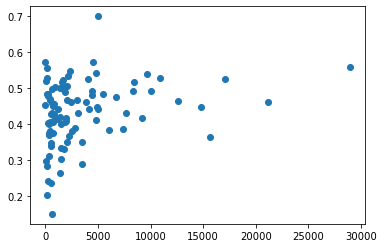

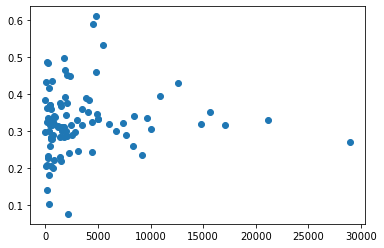

In [29]:
plt.scatter([x[0] for x in pts_trained_to_accuracy_combined.values()], [x[1] for x in pts_trained_to_accuracy_combined.values()])
plt.show()
plt.scatter([x[0] for x in pts_trained_to_accuracy_combined.values()], [x[2] for x in pts_trained_to_accuracy_combined.values()])
plt.show()

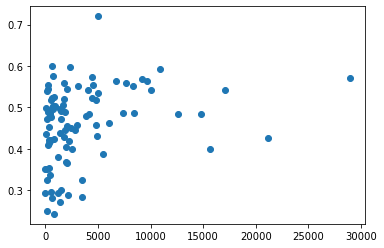

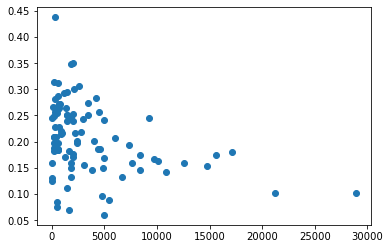

In [51]:
plt.scatter([x[0] for x in pts_trained_to_accuracy_combined2.values()], [x[1] for x in pts_trained_to_accuracy_combined2.values()])
plt.show()
plt.scatter([x[0] for x in pts_trained_to_accuracy_combined2.values()], [x[2] for x in pts_trained_to_accuracy_combined2.values()])
plt.show()

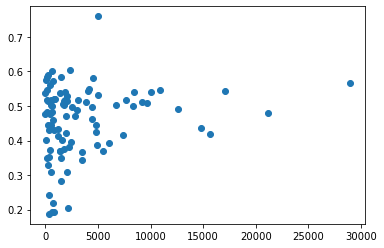

In [67]:
plt.scatter([x[0] for x in pts_trained_to_accuracy_combined3.values()], [x[1] for x in pts_trained_to_accuracy_combined3.values()])
plt.show()

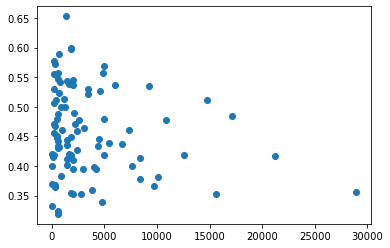

In [89]:
plt.scatter([x[0] for x in pts_trained_to_accuracy_combined4.values()], [x[1] for x in pts_trained_to_accuracy_combined4.values()])
plt.show()

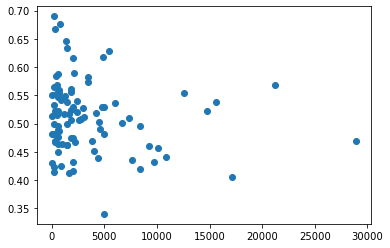

In [203]:
plt.scatter([x[0] for x in pts_trained_to_accuracy_combined5.values()], [x[1] for x in pts_trained_to_accuracy_combined5.values()])
plt.show()

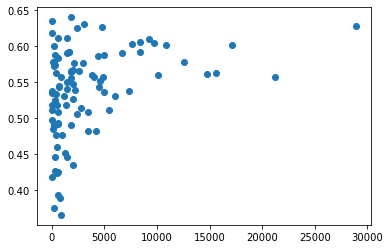

In [400]:
plt.scatter([x[0] for x in pts_trained_to_accuracy_combined6.values()], [x[1] for x in pts_trained_to_accuracy_combined6.values()])
plt.show()

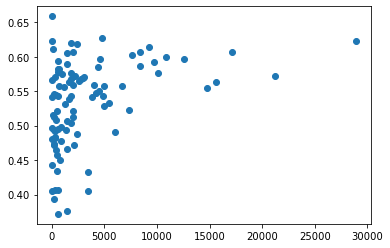

In [410]:
plt.scatter([x[0] for x in pts_trained_to_accuracy_combined7.values()], [x[1] for x in pts_trained_to_accuracy_combined7.values()])
plt.show()